In [1]:
import tenseal as ts
import tenseal.sealapi as seal
import random
import pickle
import numpy as np
import struct
import sys
import math
import array
from IPython.display import HTML, display
import tabulate
import pytest

In [2]:
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [3]:
# Type of Encryption
enc_type_str = {
    ts.ENCRYPTION_TYPE.SYMMETRIC : "symmetric", 
    ts.ENCRYPTION_TYPE.ASYMMETRIC : "asymmetric",
}

# Select Ecryption Scheme ( CKKS or BFV )
scheme_str = {
    ts.SCHEME_TYPE.CKKS : "ckks", 
    ts.SCHEME_TYPE.BFV : "bfv",
}

In [4]:
# Decrption Function
def decrypt(enc):
    return enc.decrypt()

In [5]:
def calculate_entropy(data):
    byteArr = array.array('B', data)
    fileSize = len(byteArr)
    #print(byteArr)
    #print("\n")
    
    # calculate the frequency of each byte value in the file 
    
    freqList = [] 
    for b in range(256): 
        ctr = 0 
        for byte in byteArr: 
            if byte == b: 
                ctr += 1 
        freqList.append(float(ctr) / fileSize) 
    #print(freqList)
    
    # Shannon entropy 
    
    ent = 0.0 
    for freq in freqList: 
        if freq > 0: 
            ent = ent + freq * math.log(freq, 2) 
    ent = -ent/8 
    return ent

In [6]:
def convert_mnist_to_csv(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()
convert_mnist_to_csv("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte",
        "mnist_test.csv", 10000)

In [7]:
import pandas as pd
mnist = pd.read_csv('mnist_test.csv')
mnist.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
mnist.drop(columns='7', inplace=True)
mnist.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


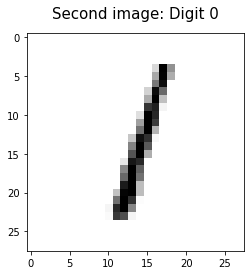

In [9]:
import matplotlib.pyplot as plt

second_image = mnist.iloc[1].values.reshape([28,28])
plt.imshow(second_image, cmap='gray_r')
plt.title('Second image: Digit 0', fontsize=15, pad=15)
plt.savefig("Second image.png")

In [10]:
image_data = mnist.iloc[1].values.reshape([28,28])
data =  ((second_image - np.min(second_image))/np.ptp(second_image)).flatten()
network_data = pickle.dumps(data)

In [11]:
enc_type = ts.ENCRYPTION_TYPE.ASYMMETRIC
ct_size_benchmarks_ckks = [["Encryption Type", 
                       "Scheme Type", 
                       "Polynomial modulus", 
                       "Coefficient modulus sizes", 
                       "Precision", 
                       "Ciphertext serialized size", 
                       "Encryption increase ratio",
                       "Bitstream Entrop"
                      ]]
decryped_data = []

In [12]:
test_parameters_ckks = [
    (8192, [60, 40, 60], 40),
    (8192, [40, 21, 21, 21, 21, 21, 21, 40], 40),
    (8192, [40, 21, 21, 21, 21, 21, 21, 40], 21),
    (8192, [40, 20, 40], 40),
    (8192, [20, 20, 20], 38),
    (8192, [60, 60], 38),
    (8192, [40, 40], 38),
    (8192, [17, 17], 15),
    (4096, [40, 20, 40], 40),
    (4096, [30, 20, 30], 40),
    (4096, [20, 20, 20], 38),
    (4096, [19, 19, 19], 35),
    (4096, [18, 18, 18], 33),
    (4096, [30, 30], 25),
    (4096, [25, 25], 20),
    (4096, [18, 18], 16),
    (4096, [17, 17], 15),
    (2048, [20, 20], 18),
    (2048, [18, 18], 16),
    (2048, [16, 16], 14),
]

In [13]:
for (poly_mod, coeff_mod_bit_sizes, prec) in test_parameters_ckks:
    context = ts.context(
        scheme=ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=poly_mod,
        coeff_mod_bit_sizes=coeff_mod_bit_sizes,
        encryption_type=enc_type,
    )
    scale = 2 ** prec
    ckks_vec = ts.ckks_vector(context, data, scale)

    enc_network_data = ckks_vec.serialize()
    ct_size_benchmarks_ckks.append([enc_type_str[enc_type], 
                               scheme_str[ts.SCHEME_TYPE.CKKS], 
                               poly_mod, coeff_mod_bit_sizes, 
                               "2**{}".format(prec),
                               convert_size(len(enc_network_data)), 
                               round(len(enc_network_data) / len(network_data), 2),
                               str(calculate_entropy(enc_network_data))
                              ])
    decryped_data.append(decrypt(ckks_vec))

print("Plain data size in bytes {}".format(convert_size(len(network_data))))
print("Entropy of Input data: " + str(calculate_entropy(network_data))) 
display(HTML(tabulate.tabulate(ct_size_benchmarks_ckks, tablefmt='html')))

Plain data size in bytes 6.28 KB
Entropy of Input data: 0.1376673401089162


Encryption Type,Scheme Type,Polynomial modulus,Coefficient modulus sizes,Precision,Ciphertext serialized size,Encryption increase ratio,Bitstream Entrop
asymmetric,ckks,8192,"[60, 40, 60]",2**40,229.89 KB,36.62,0.9943348210991277
asymmetric,ckks,8192,"[40, 21, 21, 21, 21, 21, 21, 40]",2**40,427.51 KB,68.09,0.9985614060663973
asymmetric,ckks,8192,"[40, 21, 21, 21, 21, 21, 21, 40]",2**21,428.58 KB,68.26,0.9986336781892159
asymmetric,ckks,8192,"[40, 20, 40]",2**40,153.17 KB,24.4,0.9952288728203138
asymmetric,ckks,8192,"[20, 20, 20]",2**38,104.49 KB,16.64,0.9984470054093176
asymmetric,ckks,8192,"[60, 60]",2**38,128.13 KB,20.41,0.9851417064258624
asymmetric,ckks,8192,"[40, 40]",2**38,92.18 KB,14.68,0.9982071643065507
asymmetric,ckks,8192,"[17, 17]",2**15,37.96 KB,6.05,0.9931232914276996
asymmetric,ckks,4096,"[40, 20, 40]",2**40,79.08 KB,12.59,0.9946308338039509
asymmetric,ckks,4096,"[30, 20, 30]",2**40,66.35 KB,10.57,0.999191246919976


Text(0, 0.5, 'Explained variance')

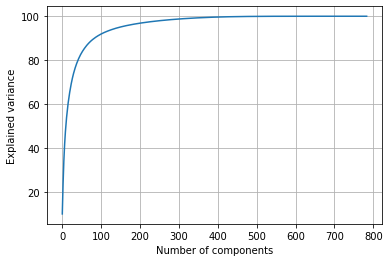

In [14]:
import numpy as np
from sklearn.decomposition import PCA

pca_784 = PCA(n_components=784)
pca_784.fit(mnist)

plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

Text(0.5, 1.0, 'Compressed image with 184 components')

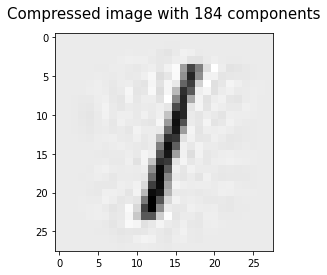

In [15]:
pca_184 = PCA(n_components=184)
mnist_pca_184_reduced = pca_184.fit_transform(mnist)
mnist_pca_184_recovered = pca_184.inverse_transform(mnist_pca_184_reduced)

image_pca_184 = mnist_pca_184_recovered[1,:].reshape([28,28])
plt.imshow(image_pca_184, cmap='gray_r')
plt.title('Compressed image with 184 components', fontsize=15, pad=15)

In [16]:
np.cumsum(pca_184.explained_variance_ratio_ * 100)[-1]

96.31809007775676

In [17]:
com_second_image = mnist_pca_184_reduced[1]
com_data =  (com_second_image - np.min(com_second_image))/np.ptp(com_second_image).flatten()
com_network_data = pickle.dumps(com_data)

com_ct_size_benchmarks_ckks = [["Encryption Type", 
                       "Scheme Type", 
                       "Polynomial modulus", 
                       "Coefficient modulus sizes", 
                       "Precision", 
                       "Ciphertext serialized size", 
                       "Encryption increase ratio",
                       "Bitstream Entropy"
                      ]]
com_decryped_data = []

In [18]:
for (poly_mod, coeff_mod_bit_sizes, prec) in test_parameters_ckks:
    context = ts.context(
        scheme=ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=poly_mod,
        coeff_mod_bit_sizes=coeff_mod_bit_sizes,
        encryption_type=enc_type,
    )
    scale = 2 ** prec
    com_ckks_vec = ts.ckks_vector(context, com_data, scale)

    com_enc_network_data = com_ckks_vec.serialize()
    com_ct_size_benchmarks_ckks.append([enc_type_str[enc_type], 
                               scheme_str[ts.SCHEME_TYPE.CKKS], 
                               poly_mod, coeff_mod_bit_sizes, 
                               "2**{}".format(prec),
                               convert_size(len(com_enc_network_data)), 
                               round(len(com_enc_network_data) / len(com_network_data), 2),
                               str(calculate_entropy(com_enc_network_data))
                              ])
    com_decryped_data.append(decrypt(com_ckks_vec))

print("Plain data size in bytes {}".format(convert_size(len(com_network_data))))
print("Entropy of Compressed Data: " + str(calculate_entropy(com_network_data))) 
display(HTML(tabulate.tabulate(com_ct_size_benchmarks_ckks, tablefmt='html')))

Plain data size in bytes 1.59 KB
Entropy of Compressed Data: 0.9019555882709982


Encryption Type,Scheme Type,Polynomial modulus,Coefficient modulus sizes,Precision,Ciphertext serialized size,Encryption increase ratio,Bitstream Entropy
asymmetric,ckks,8192,"[60, 40, 60]",2**40,229.87 KB,144.58,0.9944109999627816
asymmetric,ckks,8192,"[40, 21, 21, 21, 21, 21, 21, 40]",2**40,427.17 KB,268.69,0.9985392092959701
asymmetric,ckks,8192,"[40, 21, 21, 21, 21, 21, 21, 40]",2**21,427.93 KB,269.16,0.9985673852823792
asymmetric,ckks,8192,"[40, 20, 40]",2**40,154.28 KB,97.04,0.9957436408596443
asymmetric,ckks,8192,"[20, 20, 20]",2**38,104.4 KB,65.66,0.9986413970121786
asymmetric,ckks,8192,"[60, 60]",2**38,128.13 KB,80.6,0.9852941468642266
asymmetric,ckks,8192,"[40, 40]",2**38,92.14 KB,57.95,0.9981755043867908
asymmetric,ckks,8192,"[17, 17]",2**15,37.44 KB,23.55,0.9959377726252306
asymmetric,ckks,4096,"[40, 20, 40]",2**40,79.08 KB,49.74,0.9943207364440787
asymmetric,ckks,4096,"[30, 20, 30]",2**40,66.36 KB,41.74,0.9992759990567874
